In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

# Random Forest
The Random Forest algorithm improves on the balance problem found with the Decision Tree algorithm as it limits overfitting without substantially increasing error due to bias.

In [2]:
# evaluate random forest algorithm for classification
import pandas as pd
import numpy as np
from numpy import mean, std
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split as tts

from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

from yellowbrick.classifier import ClassificationReport
from yellowbrick.model_selection import ValidationCurve

import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [3]:
# Read in CSV
data = pd.read_csv("../../5_profiles/reduced_dim_5.csv")
# Display Data
data

,profile,.NET,ASP.NET,AWS,AWS S3,Adobe Photoshop,Agile,Agile Methodology,Agile Software Development,Ajax,...,Version Control,Visual,Visual Studio,Web API,Windows,Wireframing,WordPress,Written English,jQuery,js
0,Fullstack,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Frontend,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
2,ML,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ML,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,QA,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770,Frontend,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
771,Frontend,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
772,Frontend,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,1
773,ML,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [4]:
# Assign all columns besides the profile col as the input variables (X)
X = data.iloc[:, 1:]
# Assign the profile col as the output variable (y)
y = data.iloc[:, 0]

<IPython.core.display.Javascript object>

In [5]:
# Split to the data to test & train data
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3, random_state=0)

<IPython.core.display.Javascript object>

# Evaluating the model via Cross Validation
With machine learning algorithms which implement stochastic learning algorithms, it's good practice to evaluate them by averaging their performance across multiple runs or repeats of cross-validation. When fitting a final model, it may be a good idea to either increase the number of trees until the variance of the model is reduced across repeated evaluations, or to fit multiple final models and average their predictions.

In [6]:
# Define the Model
model = RandomForestClassifier()
# Evaluate the Model via CV
cv = RepeatedStratifiedKFold(n_repeats=3, random_state=1)
# Accuracy
acc = cross_val_score(
    model,
    X_test,
    y_test,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    error_score="raise",
)
# Balanced Accuracy
bal_acc = cross_val_score(
    model,
    X_test,
    y_test,
    scoring="balanced_accuracy",
    cv=cv,
    n_jobs=-1,
    error_score="raise",
)
# report performance with accuracy & balanced_accuracy metrics
print("Accuracy: %.3f (%.3f)" % (mean(acc), std(acc)))
print("Balanced Accuracy: %.3f (%.3f)" % (mean(bal_acc), std(bal_acc)))

Accuracy: 0.682 (0.049)
Balanced Accuracy: 0.601 (0.077)


<IPython.core.display.Javascript object>

#### The Accuracy score reported is a bit misleading as it does not account for the imbalanced classes in the data. Balanced Accuracy is a better metric as it is the average of the proportion corrects of each class individually, therefore not favoring any class in particular.

# Hypertuning Algorithm Parameters

## Exploring the Tree's Depth (max_depth)
The max_depth argument is defined as the maximum number of levels making  up each Decision Tree making up the Random Forest. Each Decision Tree has an arbitrary depth and is not pruned. While deeper trees are often more overfit to the training data, they are also less correlated, which in turn may improve the overall performance of the ensemble.

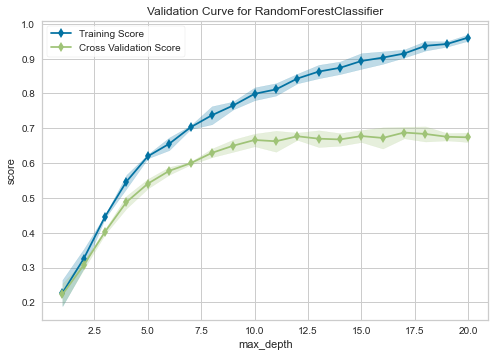

<AxesSubplot:title={'center':'Validation Curve for RandomForestClassifier'}, xlabel='max_depth', ylabel='score'>

<IPython.core.display.Javascript object>

In [7]:
viz = ValidationCurve(
    RandomForestClassifier(),
    param_name="max_depth",
    param_range=np.arange(1, 21),
    cv=3,
    scoring="balanced_accuracy",
)

# Fit the visualizer
viz.fit(X, y)
# Show the visualizer
viz.show()

#### A validation curve is a tool that measures changes in a machine learning algorithm's performance (as measured by a specified metric) with changes to a specified model hyperparameter.

### Interpreting the Plot
The Box & Whisker below aligns with Validation Curve generated above, in that peak accuracy is acheived at tree depths exceeding 10 levels.

In [8]:
# get list of models to evaluate
def get_models():
    models = dict()
    # consider tree depths from 1 to 7 and None=full
    depths = [i for i in range(1, 16)] + [None]
    for n in depths:
        models[str(n)] = RandomForestClassifier(max_depth=n)
    return models


# evaluate given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_repeats=3, random_state=0)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X, y, scoring="balanced_accuracy", cv=cv, n_jobs=-1)
    return scores

<IPython.core.display.Javascript object>

### Interpreting the Plot
The Box & Whisker below aligns with Validation Curve generated above, in that peak accuracy is acheived at tree depths exceeding 10 levels.

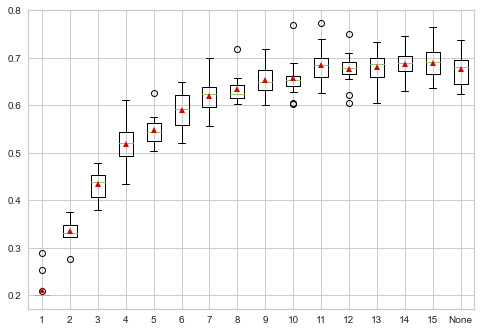

<IPython.core.display.Javascript object>

In [9]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
#     print(">%s %.3f (%.3f)" % (name, mean(scores), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

## Exploring the Number of Features (max_features)
The max_features argument is defined as the number of features that are randomly sampled at each split point or node of the tree. This is perhaps the most important feature to configure for Random Forest!

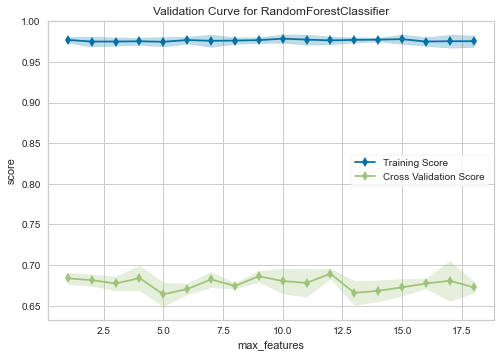

<AxesSubplot:title={'center':'Validation Curve for RandomForestClassifier'}, xlabel='max_features', ylabel='score'>

<IPython.core.display.Javascript object>

In [10]:
viz = ValidationCurve(
    RandomForestClassifier(),
    param_name="max_features",
    param_range=np.arange(1, 19),
    cv=3,
    scoring="balanced_accuracy",
)

# Fit and show the visualizer
viz.fit(X, y)
viz.show()

### Interpreting the Plot
It's clear that setting the max_features argument will not significantly impact algorithm performance, as results shown here are too stochastic to reveal any clear improvement or harm to algorithm performance. 

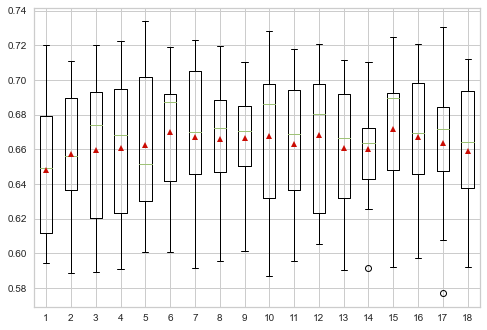

<IPython.core.display.Javascript object>

In [11]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # explore number of features from 1 to 38
    for i in range(1, 19):
        models[str(i)] = RandomForestClassifier(max_features=i)
    return models


# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_repeats=3, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(
        model, X_train, y_train, scoring="balanced_accuracy", cv=cv, n_jobs=-1
    )
    return scores


models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
#     print(">%s %.3f (%.3f)" % (name, mean(scores), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

## Using Grid Search to Explore the Best Combination of Hyperparameters

In [12]:
n_estimators = [10, 100, 1000]
max_features = ["sqrt", "log2"]
max_depth = [5, 10, 15]
# define grid search
grid = dict(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(
    estimator=model,
    param_grid=grid,
    n_jobs=-1,
    cv=cv,
    scoring="balanced_accuracy",
    error_score=0,
)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.696792 using {'max_depth': 15, 'max_features': 'log2', 'n_estimators': 1000}
0.528548 (0.055619) with: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 10}
0.550254 (0.054755) with: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100}
0.558306 (0.056641) with: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 1000}
0.501330 (0.072675) with: {'max_depth': 5, 'max_features': 'log2', 'n_estimators': 10}
0.527933 (0.053366) with: {'max_depth': 5, 'max_features': 'log2', 'n_estimators': 100}
0.533037 (0.048888) with: {'max_depth': 5, 'max_features': 'log2', 'n_estimators': 1000}
0.614958 (0.063312) with: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 10}
0.666843 (0.068641) with: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
0.671749 (0.068571) with: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 1000}
0.619222 (0.078637) with: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 10}
0.663150 (0.072890) with: {'max_

<IPython.core.display.Javascript object>

### Interpreting the Results
Whether the algorithm is trained on 10, 100 or 1000 trees doesn't significantly impact algorithm performance. But differences in max_features and max_depth arguments may.
max_features appears to be optimized at log2 of total features (118), which falls between 6-7 max_features. This number which aligns with the resuts previously returned with yellowbrick's validation curve graph. max_depth appears to be optimized at, which also aligns with the resuts previously returned with yellowbrick's validation curve graph.

In [13]:
# evaluate the hypertuned Random Forest algorithm for classification
model = RandomForestClassifier(**grid_result.best_params_)
cv = RepeatedStratifiedKFold(n_repeats=3, random_state=1)
# calculate the balanced accuracy
bal_acc = cross_val_score(
    model, X, y, scoring="balanced_accuracy", cv=cv, n_jobs=-1, error_score="raise"
)
# calculate the accuracy
acc = cross_val_score(
    model, X, y, scoring="accuracy", cv=cv, n_jobs=-1, error_score="raise"
)

<IPython.core.display.Javascript object>

In [14]:
from numpy import mean, std

# report performance
print("Balanced Accuracy: %.3f (%.3f)" % (mean(bal_acc), std(bal_acc)))
# report performance
print("Accuracy: %.3f (%.3f)" % (mean(acc), std(acc)))

Balanced Accuracy: 0.689 (0.041)
Accuracy: 0.753 (0.030)


<IPython.core.display.Javascript object>

#### The micoaverage precision, recall, f1 and accuracy **are all equal** for cases in which every instance must be classified into one, and only one class. To explain this, one can reference the formulas for precision=TP/(TP+FP) and recall=TP/(TP+FN). The numerators are equivalent, and every FN for one class is another classes's FP, which makes the denominators equivalent as well. If precision = recall, then f1 will also be equal to accuracy. 
The stochastic nature of the Random Forest algorithm may mean that the f_1 micro and accuracy metric aren't exactly equal, but they should be close.

In [15]:
print(
    "f1_micro score of random forest classifier on test set: {:.3f}".format(
        np.mean(cross_val_score(model, X_test, y_test, cv=cv, scoring="f1_micro"))
    )
)

f1_micro score of random forest classifier on test set: 0.695


<IPython.core.display.Javascript object>

The **f_1** metric is the harmonic average of the precision and recall, and is a more robust metric by which to measure algorithm performance.
The **f_1 micro** metric is useful in assessing classification problems with imbalanced classes as it uses the overall TP, FN, FP, TN to calculate F1 directly, therefore not favoring any class in particular.

# Implementing Random Forest as a Binary Algorithm with OneVRest & OneVOne

#### The (OneVRest) OVR method splits a multi-class classification problem into multiple binary problems, generating one model for each class. A binary classifier is trained for each binary problem, and predictions are made using the most confident model.

In [16]:
model = RandomForestClassifier(random_state=0)
n_classes = 5
ovr = OneVsRestClassifier(model)
ovr.fit(X_train, y_train)
y_pred = ovr.predict(X_test)
# report performance using f1_micro score
print(
    "f1_micro score of random forest classifier on test set: {:.3f}".format(
        np.mean(cross_val_score(model, X_test, y_test, cv=cv, scoring="f1_micro"))
    )
)
print(
    "accuracy score of random forest classifier on test set: {:.3f}".format(
        np.mean(cross_val_score(model, X_test, y_test, cv=cv, scoring="accuracy"))
    )
)
print(
    "balanced_accuracy score of random forest classifier on test set: {:.3f}".format(
        np.mean(
            cross_val_score(model, X_test, y_test, cv=cv, scoring="balanced_accuracy")
        )
    )
)

f1_micro score of random forest classifier on test set: 0.684
accuracy score of random forest classifier on test set: 0.684
balanced_accuracy score of random forest classifier on test set: 0.614


<IPython.core.display.Javascript object>

#### The (OneVOne) OVO method also splits a multi-class classification problem into multiple binary problems, however, a dataset is created for each class vs class scenario.
The number of datasets is equal to: (NumClasses * (NumClasses – 1)) / 2

In [17]:
model = RandomForestClassifier(random_state=0)
n_classes = 5
ovo = OneVsOneClassifier(model)
ovo.fit(X_train, y_train)
y_pred = ovo.predict(X_test)
# report performance using f1_micro score
print(
    "f1_micro score of random forest classifier on test set: {:.3f}".format(
        np.mean(cross_val_score(model, X_test, y_test, cv=cv, scoring="f1_micro"))
    )
)
print(
    "accuracy score of random forest classifier on test set: {:.3f}".format(
        np.mean(cross_val_score(model, X_test, y_test, cv=cv, scoring="accuracy"))
    )
)
print(
    "balanced_accuracy score of random forest classifier on test set: {:.3f}".format(
        np.mean(
            cross_val_score(model, X_test, y_test, cv=cv, scoring="balanced_accuracy")
        )
    )
)

f1_micro score of random forest classifier on test set: 0.684
accuracy score of random forest classifier on test set: 0.684
balanced_accuracy score of random forest classifier on test set: 0.614


<IPython.core.display.Javascript object>

### Interpreting the Results
<br>
The OVO method provides an almost neglible improvement to algorithm performance over OVR, perhaps because OVO maintains the ratio of class samples, while the OVR method actually creates class imbalance. It appears that so long as the problem doesn't consist of a great deal of classes, there is little advantages to converting a mutli-class problem to a binary one when implementing the Random Forest algorithm.